#DATA EXPLORATION & CLEANING

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [ ]:
# Load the dataset from the url
url_file = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv'
dataset = pd.read_csv(url_file)

Let’s begin the preprocessing phase by exploring the dataset.



In [ ]:
# Dataset Structure & Shape
print("\nDataset Structure:")
print(dataset.info())

print("\nDataset Shape:")
print(dataset.shape)

# Data Preview & Sample
print("\nDataset Initial Sample:")
print(dataset.head(10))

print("\nAdditional Data Sample:")
print(dataset.sample(10))


Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB
None

Dataset Shape:
(23967, 9)

Dataset Initial Sample:
        date             type registration  \
0  date unk.   Antonov An-12B       T-1206   
1  date unk.   Antonov An-12B       T-1204   
2  date unk.   Antonov An-12B       T-1201   
3  date unk.  Antonov An-12BK          NaN   
4  date unk.  Antonov An-12BP   CCCP-11815   
5  date unk.  Antonov An-12BP   CCCP-

The dataset consists of 9 columns and approximately 23,967 entries. 2 major issues can be seen:
- Presence of missing values and problematic formats that need to be handled
- Wrong dtypes: the 'date', 'fatalities', and 'year' columns need to be converted to the correct format

First, I created a subset of the dataset by dropping the columns that I will not be using to conduct the data analysis


In [ ]:
# Create a subset of the dataset
subset_dataset = dataset.drop(columns=['registration', 'location']) # these columns are per se not useful for the analysis

To address the first issue, I calculated the missing values and their respective percentages in the subset of the dataset.

In [ ]:
# Count missing values and percentages
missing_values = subset_dataset.isna().sum()
missing_values_percentages = (missing_values / len(subset_dataset)) * 100

# Round percentages
missing_values_percentages = missing_values_percentages.round(2)

# Create a dataframe with missing values and percentages and print the result
print("\nMissing Values and Percentages Before Cleaning:")
missing_values_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percentages
})

print(missing_values_summary)


Missing Values and Percentages Before Cleaning:
            Missing Values  Percentage (%)
date                     0            0.00
type                     0            0.00
operator                 4            0.02
fatalities            3938           16.43
country                  0            0.00
cat                      0            0.00
year                     0            0.00


Similarly, I created a function to calculate the problematic formats and their respective percentages.

In [ ]:
# Main problematic formats after having examined the csv file in Excel
main_problematic_patterns = ["unknown", "date unk.", "unknown country", "-", "?"]

# Create a function to count problematic values
def count_problematic_values(subset_dataset, main_problematic_patterns):
    problematic_values_counts = {}
    for column in subset_dataset.columns:
      cleaned_column = subset_dataset[column].str.lower().str.strip()
      count = cleaned_column.isin(main_problematic_patterns).sum()
      problematic_values_counts[column] = count
    return problematic_values_counts

# Count total problematic values
problematic_values_total = count_problematic_values(subset_dataset, main_problematic_patterns)

# Percentages of problematic values
total_entries = len(subset_dataset)
problematic_patterns_percentages = {col: (count / total_entries) * 100 for col, count in problematic_values_total.items()}

# Round percentages
problematic_patterns_percentages = {col: round(p, 2) for col, p in problematic_patterns_percentages.items()}

# Create a dataframe with problematic values and percentages and print the result
problematic_data_summary = pd.DataFrame({
    'Problematic Values': problematic_values_total,
    'Percentage (%)': problematic_patterns_percentages
})

print("\nProblematic Values and Percentages Before Cleaning:")
print(problematic_data_summary)


Problematic Values and Percentages Before Cleaning:
            Problematic Values  Percentage (%)
date                        61            0.25
type                        34            0.14
operator                   185            0.77
fatalities                   0            0.00
country                    857            3.58
cat                          0            0.00
year                        61            0.25


Subsequently, I defined a function to clean the problematic values by substituting them with NaN values.

In [ ]:
# Create a function to clean the problematic values: substitution with NaN
def clean_problematic_values(value, main_problematic_patterns):
    value_str = str(value).strip().lower()
    if value_str in main_problematic_patterns:
        return np.nan
    return value

# Apply the function to the subset
for col in subset_dataset.columns:
    subset_dataset[col] = subset_dataset[col].apply(clean_problematic_values, args=(main_problematic_patterns,))

# Verify cleaning of problematic values
problematic_values_after = count_problematic_values(subset_dataset, main_problematic_patterns)
print("\nCheck Cleaning Problematic Values in Each Column:")
for col, count in problematic_values_after.items():
    print(f"{col}: {count}")


Check Cleaning Problematic Values in Each Column:
date: 0
type: 0
operator: 0
fatalities: 0
country: 0
cat: 0
year: 0


At this point, I recalculated the total missing values in the subset of the dataset.

In [ ]:
# Total missing values after cleaning problematic ones
missing_values_total = subset_dataset.isna().sum()
missing_values_percentages_after = (missing_values_total / total_entries) * 100

# Create a dataframe and print result
print("\nTotal Missing Values After Processing:")
missing_values_summary_after = pd.DataFrame({
    'Missing Values': missing_values_total,
    'Percentage (%)': missing_values_percentages_after.round(2)
})
print(missing_values_summary_after)


Total Missing Values After Processing:
            Missing Values  Percentage (%)
date                    61            0.25
type                    34            0.14
operator               189            0.79
fatalities            3938           16.43
country                857            3.58
cat                      0            0.00
year                    61            0.25


Eventually, I dropped the NaN values and checked again for the presence of missing values.

In [ ]:
# Drop rows with NaN values
cleaned_dataset = subset_dataset.dropna()

# Print the shape of the dataset after dropping NaN
print(f"\nDataset Shape After Dropping NaN Values: {cleaned_dataset.shape}")

# Print again the number of missing values in each column
print("\nCheck Missing Values After Dropping NaN Values:")
print(cleaned_dataset.isna().sum())


Dataset Shape After Dropping NaN Values: (19743, 7)

Check Missing Values After Dropping NaN Values:
date          0
type          0
operator      0
fatalities    0
country       0
cat           0
year          0
dtype: int64


To address the second issue, I first converted the 'date' column to datetime format and the 'year' column to numeric format.

In [ ]:
# Transform the 'date' column from from objects into date.time
accepted_date = r'\d{2}-[A-Z]{3}-\d{4}' # using a regex which is equivalent to the date 19-MAR-2024
cleaned_dataset = cleaned_dataset[cleaned_dataset['date'].str.match(accepted_date)]
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date'], format='%d-%b-%Y', errors='coerce')

# Overwrite the 'year' column with the 'year' extracted from the 'date' column
cleaned_dataset['year'] = cleaned_dataset['date'].dt.year #to ensure the 'year' column matches the 'date' one

<ipython-input-11-057734dd4707>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date'], format='%d-%b-%Y', errors='coerce')
<ipython-input-11-057734dd4707>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['year'] = cleaned_dataset['date'].dt.year #to ensure the 'year' column matches the 'date' one


Next, I defined a function to handle values like '45+7', which represent the number of deaths before and after the accident, and then converted the column to numeric format.

In [ ]:
# Transform 'fatalities' column to handle values like '45 + 7'
def transform_fatalities(value):
  return sum(map(int, value.split('+')))

# Apply function to the column 'fatalities'
cleaned_dataset['fatalities'] = cleaned_dataset['fatalities'].apply(transform_fatalities)

# Transform the 'fatalities' column in numeric format
cleaned_dataset['fatalities'] = pd.to_numeric(cleaned_dataset['fatalities'], errors='coerce')

Eventually, I checked again the Dataset Structure, Shape & Preview.

In [ ]:
# Final Dataset Structure & Shape
print("\nFinal Dataset Structure:")
print(cleaned_dataset.info())

print("\nFinal Dataset Shape:")
print(cleaned_dataset.shape)

# Final Data Preview
print("\nFinal Data Preview:")
print(cleaned_dataset.head(10))


Final Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
Index: 19554 entries, 61 to 23966
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19554 non-null  datetime64[ns]
 1   type        19554 non-null  object        
 2   operator    19554 non-null  object        
 3   fatalities  19554 non-null  int64         
 4   country     19554 non-null  object        
 5   cat         19554 non-null  object        
 6   year        19554 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 1.1+ MB
None

Final Dataset Shape:
(19554, 7)

Final Data Preview:
         date                     type                   operator  fatalities  \
61 1919-08-02            Caproni Ca.48                    Caproni          14   
62 1919-08-11          Felixstowe Fury                        RAF           1   
63 1920-02-23         Handley Page O/7     Handley Page T

The dataset now presents 19554 entries. All columns are adjusted in the correct format.

#DATA ANALYSIS & VISUALIZATION

**1. Which country had the highest number of accidents?**

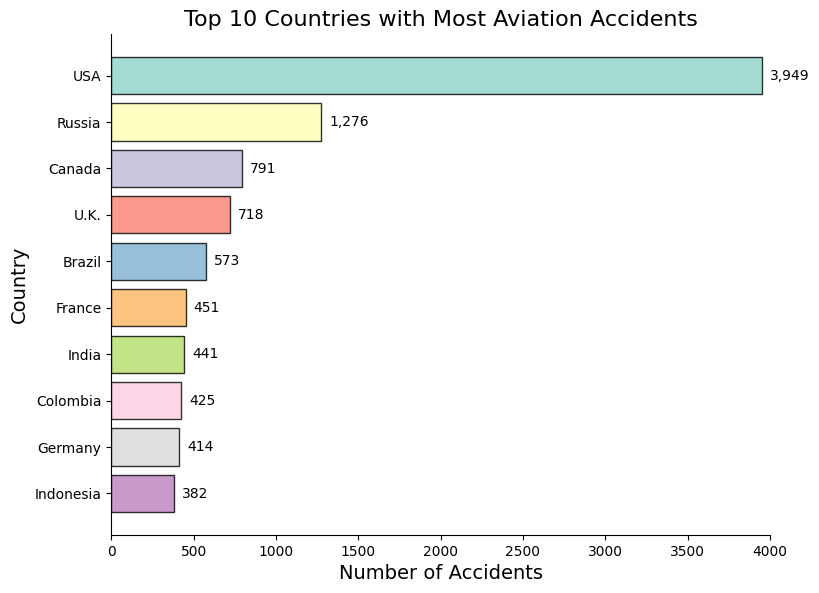

In [ ]:
# Count the incidents per country
country_counts = cleaned_dataset['country'].value_counts()

# Set the figure size
plt.figure(figsize=(8.5, 6.5))

# Define a colormap
colors = plt.cm.Set3(range(10))

# Create the horizontal bar plot
plot_1 = plt.barh(country_counts.head(10).index, country_counts.head(10).values, color=colors, edgecolor='black', alpha = 0.8)

# Title and axis labels
plt.xlabel('Number of Accidents', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.title('Top 10 Countries with Most Aviation Accidents', fontsize=16)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.xlim(0, 4000) # Range values for x axis

# Add labels to the right of the bars
for bar in plot_1:
    plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():,}',  # Adds comma to separate thousands
             va='center', ha='left', color='black', fontsize=10)

# Remove the top and right spines for clarity
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the bar plot
plt.show()

The barplot shows that USA is the country with the highest number of accidents.

**2. Which days of the week had the highest number of accidents?**

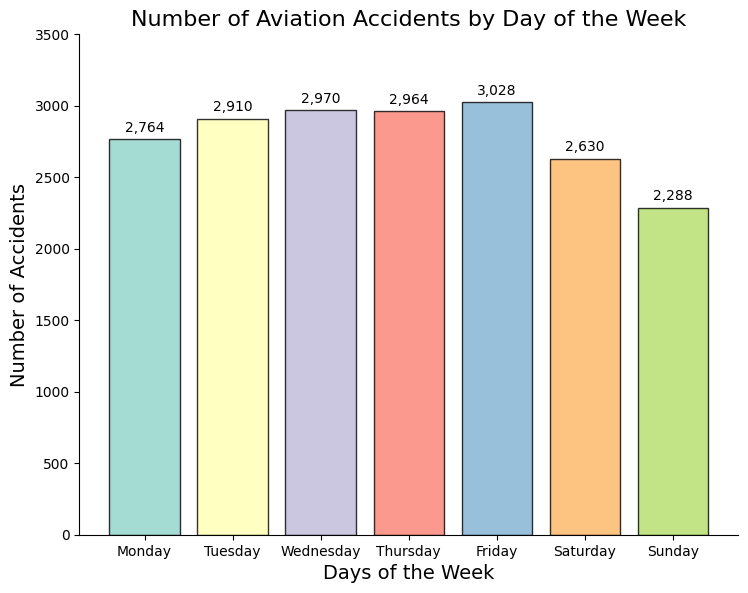

In [ ]:
# Extract the day of the week from the 'date' column
cleaned_dataset['day_of_week'] = cleaned_dataset['date'].dt.day_name()

# Count the number of accidents for each day of the week
day_of_week_counts = cleaned_dataset['day_of_week'].value_counts()

# Define the order of days from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts = day_of_week_counts.reindex(ordered_days, fill_value=0)

# Choose a colormap
colors = plt.cm.Set3(range(7))

# Create a bar plot
plt.figure(figsize=(8.5, 6.5))
plot_2 = plt.bar(day_of_week_counts.index, day_of_week_counts.values, color= colors, edgecolor='black', alpha=0.8)

# Title and axis labels
plt.xlabel('Days of the Week', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.title('Number of Aviation Accidents by Day of the Week', fontsize=16)
plt.ylim(0, 3500) # Range values for y axis

# Add labels on top of the bars
for bar in plot_2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 30,
             f'{bar.get_height():,}',  # Adds comma to separate thousands
             ha='center', va='bottom', color='black', fontsize=10)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

The barplot shows that accidents occured most frequently on Fridays and least frequently on Sundays.

**3. How did aviation accidents differ by category?**

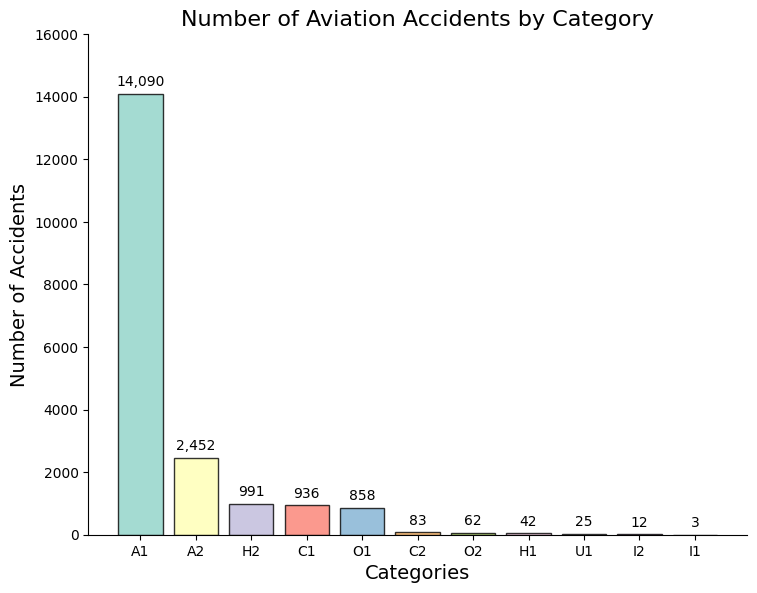

In [ ]:
# Count the number of accidents per category
category_counts = cleaned_dataset['cat'].value_counts()

# Find the category with the highest number of incidents
most_incidents_category = category_counts.max()

# Set the figure size
plt.figure(figsize=(8.5, 6.5))

# Define a colormap
colors = plt.cm.Set3(range(len(category_counts)))

# Create the vertical bar plot
plot_3 = plt.bar(category_counts.index, category_counts.values, color=colors, edgecolor='black', alpha=0.8)

# Title and axis labels
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.title('Number of Aviation Accidents by Category', fontsize=16)
plt.ylim(0, 16000)  # Adjust range values for y-axis

# Add labels on top of the bars
for bar in plot_3:
    plt.text(bar.get_x() + bar.get_width()/ 2, bar.get_height()+ 150,
             f'{int(bar.get_height()):,}',  # Adds comma to separate thousands
             ha='center', va='bottom', color='black', fontsize=10)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

The barplot shows that most of accidents were labeled with the A1 category

**4. What are the safest operators?**

To answer this question, I focused on the top 5 operators with more than 5 accidents but no deaths, i.e., when the number of fatalities was 0.

In [ ]:
# Calculate the total number of deaths and incidents for each operator
operator_stats = cleaned_dataset.groupby('operator').agg(
    total_deaths=('fatalities', 'sum'),
    number_accidents=('operator', 'count')
).reset_index()

# Create a boolean mask to filter operators with 0 deaths and more than 5 incidents
boolean_mask = (operator_stats['total_deaths'] == 0) & (operator_stats['number_accidents'] > 5)

# Apply the mask to filter the DataFrame
filtered_operators = operator_stats[boolean_mask]

# Sort operators by the number of incidents in descending order
filtered_operators = filtered_operators.sort_values(by='number_accidents', ascending=False)

# Select the top 5 operators
top_5_operators = filtered_operators.head(5)

# Display the table
print("Top 5 Safest Airlines with the Lowest Number of Deaths and more than 5 Accidents:")
print(top_5_operators)

Top 5 Safest Airlines with the Lowest Number of Deaths and more than 5 Accidents:
                     operator  total_deaths  number_accidents
4353                  Ryanair             0                13
5197  Trans Maldivian Airways             0                12
1354          Buffalo Airways             0                11
5369               US Airways             0                 9
5471       Universal Airlines             0                 9


Ryanair appears to be the safest operator, with 13 accidents but no deaths.

**5.What are the most dangerous aircraft types?**


To answer this question, I considered the top 5 aircraft types with the highest number of deaths.

In [ ]:
# Calculate total fatalities for each type of aircraft
aircraft_deaths = cleaned_dataset.groupby('type').agg(
    total_deaths=('fatalities', 'sum')
).reset_index()

# Sort by total fatalities in descending order
sorted_aircraft_deaths = aircraft_deaths.sort_values(by='total_deaths', ascending=False)

# Display the top 5 aircraft types with the highest number of fatalities
top_5_aircraft_deaths = sorted_aircraft_deaths.head(5)

print("Top 5 Aircraft Types with the Highest Number of Fatalities:")
print(top_5_aircraft_deaths)

Top 5 Aircraft Types with the Highest Number of Fatalities:
                      type  total_deaths
1683  Douglas C-47A (DC-3)          5770
1680   Douglas C-47 (DC-3)          2627
1684  Douglas C-47B (DC-3)          1992
1018      Boeing 767-223ER          1692
2949       Tupolev Tu-154M          1600


The Douglas C-47A is by far the most dangerous aircraft type, with 5,770 deaths.

**6. How the accidents evolved between 1919 and 2023?**

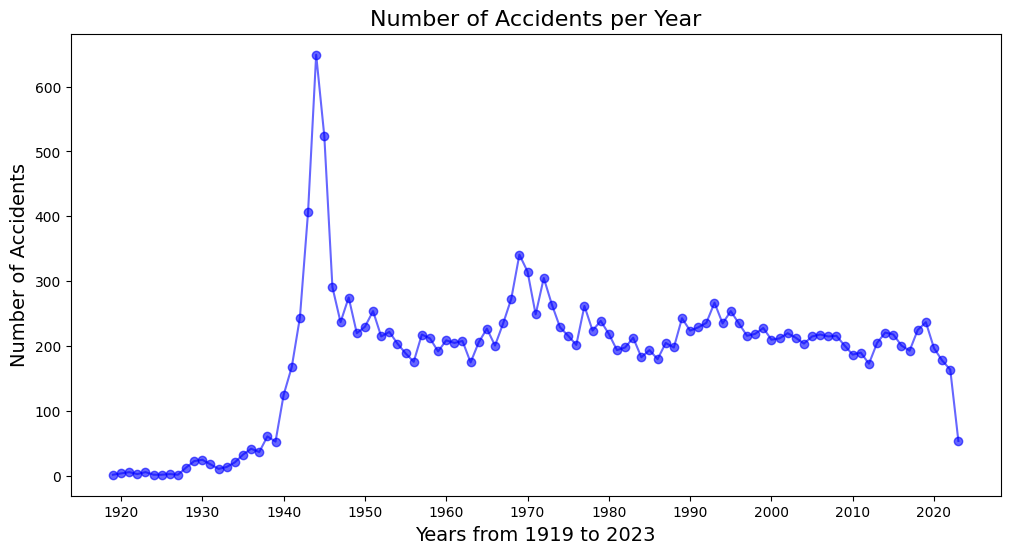

In [ ]:
# Calculate the number of accidents per year
accidents_per_year = cleaned_dataset['year'].value_counts().sort_index()

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year.index, accidents_per_year.values, marker='o', color='blue', alpha = 0.6)

# Add title and labels
plt.title('Number of Accidents per Year',  fontsize=16)
plt.xlabel('Years from 1919 to 2023',  fontsize=14)
plt.ylabel('Number of Accidents',  fontsize=14)

# Set x-axis ticks to be every 10 years from 1920 to 2030
plt.xticks(ticks=range(1920, 2030, 10))

# Show linechart
plt.show()

The line chart shows that most accidents occurred between 1940 and 1945, likely due to World War II.

**6. How the accidents evolved after the 11th of September 2001?**

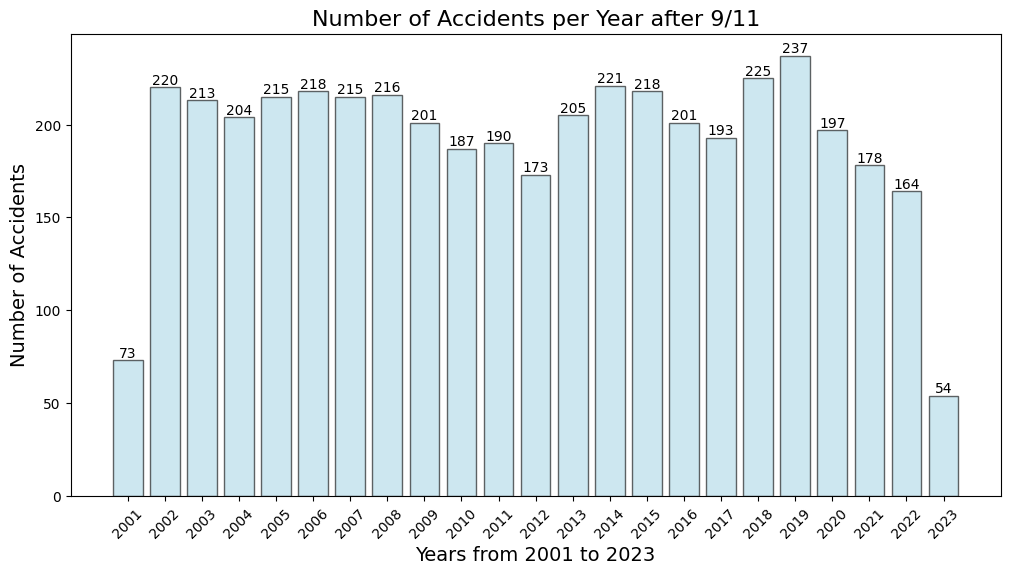

In [ ]:
# Filter incidents after 09/11/2001 for a more detailed analysis
september_11_2001 = pd.Timestamp('2001-09-11')
post_9_11_dataset = cleaned_dataset[cleaned_dataset['date'] > september_11_2001]

# Calculate the number of incidents per year after 09/11/2001
accidents_per_year_post_9_11 = post_9_11_dataset['year'].value_counts().sort_index()

# Create a barplot
plt.figure(figsize=(12, 6))
plot_4 = plt.bar(accidents_per_year_post_9_11.index, accidents_per_year_post_9_11.values, color='lightblue', alpha=0.6, edgecolor='black')

# Add title and labels
plt.title('Number of Accidents per Year after 9/11', fontsize=16)
plt.xlabel('Years from 2001 to 2023', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)

# Set x-axis ticks to show each year
plt.xticks(accidents_per_year_post_9_11.index, rotation=45)

# Add labels above the bars
for bar in plot_4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)

# Show plot
plt.show()

The line chart shows that the number of accidents does not change consistently after 9/11. However, there is a noticeable decrease after 2020, likely due to the pandemic and the reduction in flights during lockdowns. On the other hand, 2023 is the year with the least number of accidents.

#BONUS PROJECT! CREATING A CARTOGRAM

In [ ]:
# Create a dataframe with the top 10 countries
data_country = {
    'country': ['USA', 'Russia', 'Canada', 'UK', 'Brazil', 'France', 'India', 'Colombia', 'Germany', 'Indonesia'],
    'accident_count': [3966, 1284, 791, 719, 573, 452, 444, 434, 417, 383]
}
top_10_nations = pd.DataFrame(data_country)

# URL raw GeoJSON
geojson_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"

# Load world map
world = gpd.read_file(geojson_url)

# List unique values of the countries in the GeoJSON url
world_countries = world['name'].unique()

# Verify which countries in the dataset exist in the map world
existing_countries = [country for country in top_10_nations['country'] if country in world_countries]
non_existing_countries = [country for country in top_10_nations['country'] if country not in world_countries]

print("Existing countries:", existing_countries)
print("Non-existing countries:", non_existing_countries)

Existing countries: ['Russia', 'Canada', 'Brazil', 'France', 'India', 'Colombia', 'Germany', 'Indonesia']
Non-existing countries: ['USA', 'UK']


In [ ]:
# Sobstitute non-existing countries in the correct format
country_mapping = {
    'USA': 'United States of America',
    'UK': 'United Kingdom'
}

# Substitute country names in the dataset with the corresponding ones on the world map
top_10_nations['country'] = top_10_nations['country'].replace(country_mapping)

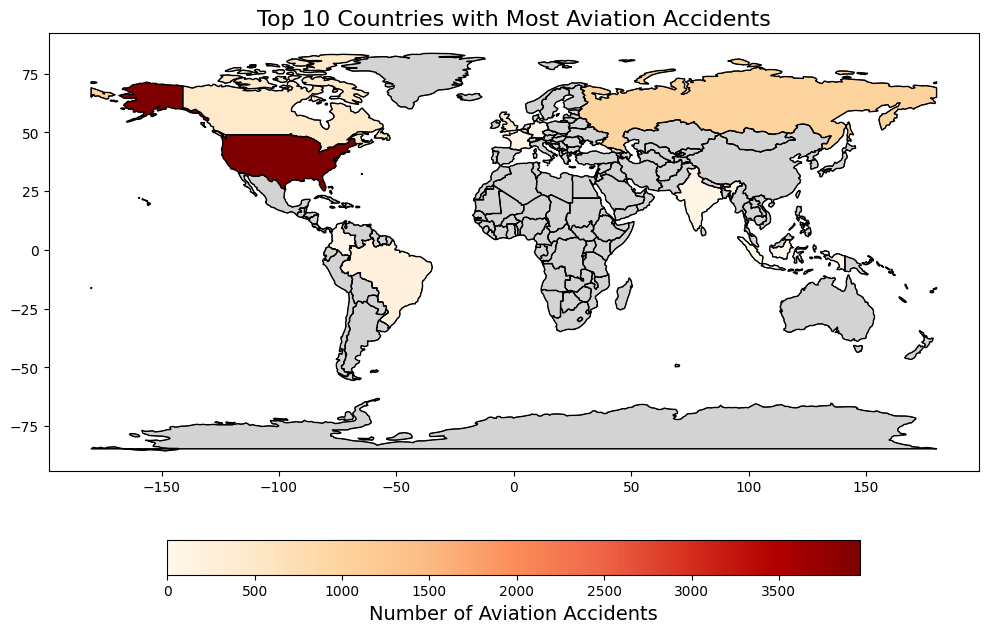

In [ ]:
# Merge the data with the world map
world_accs = world.merge(top_10_nations, how='left', left_on='name', right_on='country')

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# Plot the world map with boundaries
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Plot the top 10 countries with the number of accidents
world_accs.plot(column='accident_count', ax=ax,
                cmap='OrRd',  # Colormap from dark red to light red
                edgecolor='black',
                missing_kwds={"color": "lightgrey"}) # Color in grey the other countries

# Add a horizontal color bar
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=world_accs['accident_count'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Number of Aviation Accidents', fontsize=14)

# Title
plt.title('Top 10 Countries with Most Aviation Accidents', fontsize=16)

# Show map
plt.show()